<a href="https://colab.research.google.com/github/martinkenas/Road-Segmentation-for-type-wetness-and-roughness/blob/main/model_training_scripts/KELIO_SIURKST_Yolov8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title PILNAS ŠIURKŠTUMO 1. Sąranka ir diegimas

# Įdiegiame būtinas bibliotekas
!pip install ultralytics


from sklearn.model_selection import train_test_split
#@title 1. Import Libraries (Combined)
import os
import yaml
import random
import shutil
from datetime import datetime
from PIL import Image as PILImage
from sklearn.model_selection import train_test_split
import numpy as np
import cv2 # Make sure cv2 is imported early if used in helper functions
import albumentations as A # Import albumentations
from tqdm import tqdm # Import tqdm
import torch # Import torch
import glob # Import glob
import logging # Import logging
from google.colab import drive
from IPython.display import display, Image # Import display tools
from ultralytics import YOLO # Import YOLO
from ultralytics.data.dataset import YOLODataset # Import YOLODataset
from functools import partial # Import partial
import ultralytics.data.build as build # Import build
import time # Import time
import traceback # Import traceback


# Prijungiame Google Drive
drive.mount('/content/drive')

print("Sąranka baigta!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 882.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Mounted at /content/drive
Sąranka baigta!


In [ ]:
#@title 2. Projekto struktūros konfigūravimas kelio dangos šiurkštumo nustatymui

import os
import yaml
import random
import shutil
from datetime import datetime
from PIL import Image as PILImage
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
import albumentations as A
from tqdm import tqdm
import torch
import glob
import logging
from google.colab import drive
from IPython.display import display, Image
from ultralytics import YOLO
import time
import traceback

# Baziniai katalogai kelio dangos šiurkštumo segmentavimui
base_dir = '/content/drive/MyDrive/Dangos Siurkstumo Nustatymas'
print(f"Pagrindinis katalogas: {base_dir}")

# Šaltinio katalogai vaizdams ir žymėms
images_dir_source = os.path.join(base_dir, 'Images(kaukes)')  # Pervardinta, kad nesipainiotų su dataset_root images
original_labels_dirs = {
    'Lygus': os.path.join(base_dir, 'labels2', 'Lygus'),
    'Siurkstus': os.path.join(base_dir, 'labels2', 'Siurkstus'),
    'LabaiSiurkstus': os.path.join(base_dir, 'labels2', 'LabaiSiurkstus')
}

# Sukuriame laiko žymą unikaliam projekto paleidimui
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
project_dir = os.path.join(base_dir, f'road_roughness_seg_{timestamp}')
os.makedirs(project_dir, exist_ok=True)

# Rezultatų katalogai
results_dir = os.path.join(project_dir, 'results')
predictions_dir = os.path.join(project_dir, 'predictions')
exports_dir = os.path.join(project_dir, 'exports')
os.makedirs(results_dir, exist_ok=True)
os.makedirs(predictions_dir, exist_ok=True)
os.makedirs(exports_dir, exist_ok=True)

# Sukuriame duomenų rinkinio katalogų struktūrą
dataset_root = os.path.join(base_dir, f'road_roughness_dataset_{timestamp}')
os.makedirs(dataset_root, exist_ok=True)

# Sukuriame YOLO duomenų rinkinio struktūrą
for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(dataset_root, 'images', split), exist_ok=True)
    os.makedirs(os.path.join(dataset_root, 'labels', split), exist_ok=True)


Pagrindinis katalogas: /content/drive/MyDrive/Dangos Siurkstumo Nustatymas


In [ ]:
#@title 3. Duomenų rinkinio analizė ir padalijimų sukūrimas kelio dangos šiurkštumui

def analyze_roughness_dataset():
    """Analizuoti kelio dangos šiurkštumo duomenų rinkinį ir sukurti padalijimus"""
    # Gauname visus pažymėtus failus iš kiekvieno katalogo
    all_files = {}

    # Skaičiuojame failus kiekvienai šiurkštumo klasei
    type_counts = {}

    # Klasės indeksų žemėlapis (konvertuojame iš originalių klasių į 0, 1, 2)
    class_id_map = {"Lygus": 0, "Siurkstus": 1, "LabaiSiurkstus": 2}

    for roughness_type, label_dir in original_labels_dirs.items():
        files = []
        class_id = class_id_map[roughness_type]

        # Gauname visus txt failus, išskyrus classes.txt
        for file in os.listdir(label_dir):
            if file.endswith('.txt') and file != 'classes.txt':
                base_name = os.path.splitext(file)[0]
                # Tikriname, ar egzistuoja atitinkamas vaizdas
                img_path = None
                for ext in ['.jpg', '.jpeg', '.png']:
                    if os.path.exists(os.path.join(images_dir_source, base_name + ext)):
                        img_path = os.path.join(images_dir_source, base_name + ext)
                        break

                if img_path:
                    files.append({
                        'base_name': base_name,
                        'img_path': img_path,
                        'label_path': os.path.join(label_dir, file),
                        'roughness_type': roughness_type,
                        'class_id': class_id  # Naudojame tikslinį klasės ID (0, 1 arba 2)
                    })

        all_files[roughness_type] = files
        type_counts[roughness_type] = len(files)

    # Spausdiname statistiką
    print("\nDuomenų rinkinio statistika:")
    total_files = sum(type_counts.values())
    for roughness_type, count in type_counts.items():
        print(f"  {roughness_type}: {count} failai ({count/total_files*100:.1f}%)")
    print(f"  Iš viso: {total_files} failai")

    # Sukuriame padalijimus (70% train, 15% val, 15% test)
    splits = {'train': [], 'val': [], 'test': []}

    for roughness_type, files in all_files.items():
        # Padalijame failus
        train_files, temp = train_test_split(
            files, test_size=0.3, random_state=42
        )
        val_files, test_files = train_test_split(
            temp, test_size=0.5, random_state=42  # 0.3 * 0.5 = 0.15 for val and test
        )

        # Pridedame į padalijimus
        splits['train'].extend(train_files)
        splits['val'].extend(val_files)
        splits['test'].extend(test_files)

    # Spausdiname padalijimų statistiką
    print("\nPadalijimų statistika:")
    for split_name, files in splits.items():
        print(f"  {split_name}: {len(files)} failai")

        # Skaičiuojame pagal šiurkštumo tipą
        split_counts = {}
        for file in files:
            rt = file['roughness_type']
            split_counts[rt] = split_counts.get(rt, 0) + 1

        for rt, count in split_counts.items():
            print(f"    - {rt}: {count} failai ({count/len(files)*100:.1f}%)")

    return splits, type_counts

# Analizuojame duomenų rinkinį ir sukuriame padalijimus
splits, class_counts = analyze_roughness_dataset()


Duomenų rinkinio statistika:
  Lygus: 560 failai (40.5%)
  Siurkstus: 312 failai (22.6%)
  LabaiSiurkstus: 511 failai (36.9%)
  Iš viso: 1383 failai

Padalijimų statistika:
  train: 967 failai
    - Lygus: 392 failai (40.5%)
    - Siurkstus: 218 failai (22.5%)
    - LabaiSiurkstus: 357 failai (36.9%)
  val: 208 failai
    - Lygus: 84 failai (40.4%)
    - Siurkstus: 47 failai (22.6%)
    - LabaiSiurkstus: 77 failai (37.0%)
  test: 208 failai
    - Lygus: 84 failai (40.4%)
    - Siurkstus: 47 failai (22.6%)
    - LabaiSiurkstus: 77 failai (37.0%)


In [ ]:
#@title 4. Duomenų rinkinio failų apdorojimas su tikslinėmis augmentacijomis šiurkštumo nustatymui

def process_roughness_dataset_files():
    """Apdoroti kelio dangos šiurkštumo duomenų rinkinio failus ir paruošti mokymui,
    taikant tikslinius augmentavimus ir įtraukiant svorius į dataset.yaml.
    """
    print("\nApdorojame kelio dangos šiurkštumo duomenų rinkinio failus su tikslinėmis augmentacijomis...")

    # --- Augmentacijų apibrėžimas kiekvienai šiurkštumo klasei ---
    # Bendros tekstūrinės augmentacijos
    texture_aug = A.Compose([
        A.OneOf([
            A.Sharpen(alpha=(0.2, 0.5), lightness=(0.7, 1.0), p=0.5),
            A.Emboss(alpha=(0.2, 0.5), strength=(0.5, 1.0), p=0.5),
        ], p=0.7),
        A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), p=0.5),
    ])

    # Apšvietimo augmentacijos lygiai dangai
    lighting_smooth_aug = A.Compose([
        A.RandomShadow(shadow_roi=(0, 0, 1, 1), p=0.7),
        A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.3), contrast_limit=(-0.1, 0.3), p=0.7),
    ])

    # Struktūrinės augmentacijos labai šiurkščiai dangai
    structure_aug = A.Compose([
        A.GaussNoise(var_limit=(10, 50), p=0.6),
        A.RandomBrightnessContrast(brightness_limit=(-0.4, 0.1), contrast_limit=(0.1, 0.4), p=0.6),
        A.Sharpen(alpha=(0.3, 0.7), lightness=(0.5, 1.0), p=0.7),
    ])

    # Kontrastinės augmentacijos šiurkščiai dangai
    contrast_aug = A.Compose([
        A.RandomBrightnessContrast(brightness_limit=(-0.3, 0.3), contrast_limit=(0.1, 0.5), p=0.8),
        A.Sharpen(alpha=(0.2, 0.4), lightness=(0.6, 1.0), p=0.5),
    ])

    # Vaizdų pagerinimo funkcijos
    def enhance_texture_features(image, roughness_type):
        """Pagerinti tekstūros matomumą naudojant kontrastingus metodus"""
        # Bazinės korekcijos visiems vaizdams
        lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        l = clahe.apply(l)
        enhanced_lab = cv2.merge([l, a, b])
        enhanced = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2BGR)

        # Specifiniai patobulinimai pagal šiurkštumo tipą
        if roughness_type == 'LabaiSiurkstus':
            # Labai šiurkščiai dangai: didelis kontrastas ir ryškumas
            alpha = 1.25  # Didesnis kontrastas
            beta = 10     # Didesnis ryškumas
        elif roughness_type == 'Siurkstus':
            # Šiurkščiai dangai: vidutinis kontrastas
            alpha = 1.15  # Vidutinis kontrastas
            beta = 5      # Vidutinis ryškumas
        else:  # 'Lygus'
            # Lygiai dangai: subtilus kontrastas
            alpha = 1.05  # Subtilus kontrastas
            beta = 3      # Subtilus ryškumas

        enhanced = cv2.convertScaleAbs(enhanced, alpha=alpha, beta=beta)
        return enhanced

    # Klasių ID žemėlapis
    class_id_map = {"Lygus": 0, "Siurkstus": 1, "LabaiSiurkstus": 2}
    original_class_ids = {"Lygus": 5, "Siurkstus": 6, "LabaiSiurkstus": 7}  # Tarsime, kad originalūs ID yra 5, 6, 7

    # Pagalbinė funkcija žymių failų kopijavimui
    def copy_modify_label(src_label_path, dst_label_path, roughness_type):
        """Nukopijuoti žymių failą, pakeičiant klasės ID iš originalaus į tikslinį."""
        original_id = original_class_ids[roughness_type]
        target_class_id = class_id_map[roughness_type]

        try:
            with open(src_label_path, 'r') as src_file:
                lines = src_file.readlines()

            modified_content = []
            for line in lines:
                parts = line.strip().split()
                if len(parts) >= 5:
                    current_class = int(parts[0])
                    if current_class == original_id:
                        parts[0] = str(target_class_id)
                        modified_content.append(' '.join(parts))

            if modified_content:
                with open(dst_label_path, 'w') as dst_file:
                    dst_file.write('\n'.join(modified_content))

        except Exception as e:
            print(f"Klaida apdorojant žymės failą {src_label_path} į {dst_label_path}: {e}")

    # Augmentuotų pavyzdžių skaitiklis
    augmented_samples = {'train': 0, 'val': 0, 'test': 0}

    # Apdorojame failus
    for split, files in splits.items():
        for file_data in tqdm(files, desc=f"Apdorojame {split} rinkinį"):
            img_path = file_data['img_path']
            label_path = file_data['label_path']
            base_name = file_data['base_name']
            class_id = file_data['class_id']
            roughness_type = file_data['roughness_type']

            dest_img_path = os.path.join(dataset_root, 'images', split, f"{base_name}.jpg")
            dest_label_path = os.path.join(dataset_root, 'labels', split, f"{base_name}.txt")

            img = cv2.imread(img_path)
            if img is None:
                print(f"Įspėjimas: nepavyko perskaityti vaizdo {img_path}")
                continue

            # Taikome specifinį vaizdų tobulinimą pagal šiurkštumo tipą
            processed_img = enhance_texture_features(img.copy(), roughness_type)

            cv2.imwrite(dest_img_path, processed_img)
            copy_modify_label(label_path, dest_label_path, roughness_type)

            # Augmentacijos tik mokymo rinkiniui
            if split == 'train':
                if roughness_type == 'Lygus':
                    # Lygiems keliams taikome apšvietimo augmentacijas
                    if random.random() < 0.8:
                        smooth_aug_img = lighting_smooth_aug(image=processed_img)['image']
                        smooth_aug_img_path = os.path.join(dataset_root, 'images', split, f"{base_name}_smooth_aug.jpg")
                        smooth_aug_label_path = os.path.join(dataset_root, 'labels', split, f"{base_name}_smooth_aug.txt")
                        cv2.imwrite(smooth_aug_img_path, smooth_aug_img)
                        copy_modify_label(label_path, smooth_aug_label_path, roughness_type)
                        augmented_samples[split] += 1

                elif roughness_type == 'Siurkstus':
                    # Šiurkštiems keliams taikome kontrastines augmentacijas
                    if random.random() < 0.8:
                        contrast_aug_img = contrast_aug(image=processed_img)['image']
                        contrast_aug_img_path = os.path.join(dataset_root, 'images', split, f"{base_name}_contrast_aug.jpg")
                        contrast_aug_label_path = os.path.join(dataset_root, 'labels', split, f"{base_name}_contrast_aug.txt")
                        cv2.imwrite(contrast_aug_img_path, contrast_aug_img)
                        copy_modify_label(label_path, contrast_aug_label_path, roughness_type)
                        augmented_samples[split] += 1

                elif roughness_type == 'LabaiSiurkstus':
                    # Labai šiurkštiems keliams taikome struktūrines augmentacijas
                    if random.random() < 0.8:
                        structure_aug_img = structure_aug(image=processed_img)['image']
                        structure_aug_img_path = os.path.join(dataset_root, 'images', split, f"{base_name}_structure_aug.jpg")
                        structure_aug_label_path = os.path.join(dataset_root, 'labels', split, f"{base_name}_structure_aug.txt")
                        cv2.imwrite(structure_aug_img_path, structure_aug_img)
                        copy_modify_label(label_path, structure_aug_label_path, roughness_type)
                        augmented_samples[split] += 1

                # Papildomai dar visiems tipams taikome bendras tekstūrines augmentacijas
                if random.random() < 0.5:  # Taikome tik daliai įrašų, kad išlaikytume augmentacijos apimtį
                    texture_aug_img = texture_aug(image=processed_img)['image']
                    texture_aug_img_path = os.path.join(dataset_root, 'images', split, f"{base_name}_texture_aug.jpg")
                    texture_aug_label_path = os.path.join(dataset_root, 'labels', split, f"{base_name}_texture_aug.txt")
                    cv2.imwrite(texture_aug_img_path, texture_aug_img)
                    copy_modify_label(label_path, texture_aug_label_path, roughness_type)
                    augmented_samples[split] += 1

    # Spausdiname augmentacijos statistiką
    print("\nAugmentacijos statistika:")
    for split_name, count in augmented_samples.items():
        if count > 0:
            print(f"  Pridėta {count} augmentuotų pavyzdžių į {split_name} rinkinį")

    total_augmented = sum(augmented_samples.values())
    print(f"  Iš viso augmentuotų pavyzdžių: {total_augmented}")

    original_total = sum(len(files) for files in splits.values())
    final_total = original_total + total_augmented
    print(f"  Galutinis duomenų rinkinio dydis: {final_total} vaizdai")

    # Apskaičiuojame svorius klasėms dataset.yaml failui
    class_weights = {}
    total_samples = sum(class_counts.values())
    num_classes = len(class_counts)

    for roughness_type, count in class_counts.items():
        if count > 0:
            # Atvirkštinio dažnio svoriai
            class_weights[class_id_map[roughness_type]] = total_samples / (num_classes * count)
        else:
            class_weights[class_id_map[roughness_type]] = 1.0

    # Normalizuojame svorius, kad jų suma būtų 1.0
    weight_sum = sum(class_weights.values())
    if weight_sum > 0:
        for k in class_weights:
            class_weights[k] = class_weights[k] / weight_sum

    # Apvaliname rodymui
    formatted_weights = {k: round(v, 4) for k, v in class_weights.items()}
    print(f"\nApskaičiuoti klasių svoriai dataset.yaml failui: {formatted_weights}")

    # Sukuriame dataset.yaml su klasių svoriais
    dataset_yaml = os.path.join(dataset_root, 'dataset.yaml')
    yaml_content = {
        'path': dataset_root,
        'train': os.path.join('images', 'train'),
        'val': os.path.join('images', 'val'),
        'test': os.path.join('images', 'test'),
        'names': {0: 'Lygus', 1: 'Siurkstus', 2: 'LabaiSiurkstus'},
        'nc': 3,  # 3 klasės
        'weights': list(class_weights.values())  # Pridedame klasių svorius į YAML
    }

    with open(dataset_yaml, 'w') as f:
        yaml.dump(yaml_content, f)

    print(f"\nDuomenų rinkinio konfigūracija su svoriais sukurta: {dataset_yaml}")
    print("Duomenų rinkinio struktūra sukurta su originaliais + tiksliniais augmentuotais pavyzdžiais.")

    return dataset_yaml

# Keičiame ankstesnę process_dataset_files funkciją į šią atnaujintą versiją kelio šiurkštumui
dataset_yaml = process_roughness_dataset_files()


<ipython-input-4-fc4ad95ab245>:27: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10, 50), p=0.6),



Apdorojame kelio dangos šiurkštumo duomenų rinkinio failus su tikslinėmis augmentacijomis...


Apdorojame test rinkinį: 100%|██████████| 208/208 [06:01<00:00,  1.74s/it]


Augmentacijos statistika:
  Pridėta 1267 augmentuotų pavyzdžių į train rinkinį
  Iš viso augmentuotų pavyzdžių: 1267
  Galutinis duomenų rinkinio dydis: 2650 vaizdai

Apskaičiuoti klasių svoriai dataset.yaml failui: {0: 0.257, 1: 0.4613, 2: 0.2817}

Duomenų rinkinio konfigūracija su svoriais sukurta: /content/drive/MyDrive/Dangos Siurkstumo Nustatymas/road_roughness_dataset_20250512_131902/dataset.yaml
Duomenų rinkinio struktūra sukurta su originaliais + tiksliniais augmentuotais pavyzdžiais.


Pradedamas mokymo procesas...

Ruošiame kelio dangos šiurkštumo segmentavimo mokymą su optimizuotais parametrais...


100%|██████████| 6.74M/6.74M [00:00<00:00, 146MB/s]


Naudojamas modelis: yolov8n-seg

Pradedame mokymą ant 0
Vaizdo dydis: 800, Partijos dydis: 12, Epochos: 120
Naudojami svoriai iš dataset.yaml.
Naudojami optimizuoti parametrai kelio dangos šiurkštumo nustatymui.
Ultralytics 8.3.132 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=12, bgr=0.0, box=7.5, cache=ram, cfg=None, classes=None, close_mosaic=20, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/drive/MyDrive/Dangos Siurkstumo Nustatymas/road_roughness_dataset_20250512_131902/dataset.yaml, degrees=5.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.1, dynamic=False, embed=None, epochs=120, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.5, hsv_v=0.4, imgsz=800, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0002, 

100%|██████████| 755k/755k [00:00<00:00, 27.3MB/s]

Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

  9                  -1  1    164608  ultralytics.nn.modules.block.SPPF            [256, 256, 5]                 
 10                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 11             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 12                  -1  1    148224  ultralytics.nn.modules.block.C2f             [384, 128, 1]                 
 13                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 14             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 15                  -1  1     37248  ultralytics.nn.modules.block.C2f             [192, 64, 1]                  
 16                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
 17            [-1, 12]  1         0  ultralytics.nn.modules.conv.Concat           [1]  

100%|██████████| 5.35M/5.35M [00:00<00:00, 116MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.5±0.1 ms, read: 93.3±24.6 MB/s, size: 1083.2 KB)


train: Scanning /content/drive/MyDrive/Dangos Siurkstumo Nustatymas/road_roughness_dataset_20250512_131902/labels/train... 2234 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2234/2234 [00:35<00:00, 62.14it/s] 


train: New cache created: /content/drive/MyDrive/Dangos Siurkstumo Nustatymas/road_roughness_dataset_20250512_131902/labels/train.cache
WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (3.0GB RAM): 100%|██████████| 2234/2234 [03:47<00:00,  9.84it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.6±0.4 ms, read: 32.2±28.5 MB/s, size: 1072.9 KB)


val: Scanning /content/drive/MyDrive/Dangos Siurkstumo Nustatymas/road_roughness_dataset_20250512_131902/labels/val... 208 images, 0 backgrounds, 0 corrupt: 100%|██████████| 208/208 [00:02<00:00, 101.85it/s]


val: New cache created: /content/drive/MyDrive/Dangos Siurkstumo Nustatymas/road_roughness_dataset_20250512_131902/labels/val.cache
WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.3GB RAM): 100%|██████████| 208/208 [00:17<00:00, 11.98it/s]


Plotting labels to /content/drive/MyDrive/Dangos Siurkstumo Nustatymas/road_roughness_seg_20250512_131902/road_roughness_model/labels.jpg... 
optimizer: AdamW(lr=0.0002, momentum=0.937) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.00046875), 76 bias(decay=0.0)
Image sizes 800 train, 800 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/Dangos Siurkstumo Nustatymas/road_roughness_seg_20250512_131902/road_roughness_model
Starting training for 120 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/120      3.03G     0.7831        1.2      1.801       1.24          3        800: 100%|██████████| 187/187 [01:15<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.64it/s]

                   all        208        241      0.572      0.683      0.717       0.63      0.568      0.674      0.712      0.427



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/120      3.39G     0.5533     0.6414      1.005      1.063          2        800: 100%|██████████| 187/187 [01:08<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.71it/s]

                   all        208        241      0.703      0.883      0.859      0.779      0.723       0.84      0.855      0.823



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/120       3.4G     0.4957     0.5152     0.8378      1.015          4        800: 100%|██████████| 187/187 [01:08<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.61it/s]

                   all        208        241      0.765      0.725      0.834      0.738      0.764      0.724      0.834      0.805



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/120      3.43G      0.474     0.5299     0.8034     0.9985          2        800: 100%|██████████| 187/187 [01:07<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.84it/s]


                   all        208        241      0.928      0.829      0.926      0.869      0.928      0.829      0.927      0.904

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/120      3.45G     0.4446      0.443     0.6737     0.9685          5        800: 100%|██████████| 187/187 [01:08<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.64it/s]

                   all        208        241      0.913      0.868      0.939      0.883       0.91      0.866      0.939      0.915



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/120      3.46G     0.4124     0.4404     0.6334     0.9586          3        800: 100%|██████████| 187/187 [01:07<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.42it/s]


                   all        208        241      0.925      0.851      0.918      0.884      0.925      0.851       0.92      0.898

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/120      3.49G     0.4068     0.4404     0.6474     0.9531          5        800: 100%|██████████| 187/187 [01:07<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.67it/s]

                   all        208        241      0.887      0.899      0.923       0.88      0.884      0.897      0.921      0.899



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/120      3.51G     0.3866     0.4044     0.5936     0.9376          2        800: 100%|██████████| 187/187 [01:06<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.76it/s]

                   all        208        241      0.914      0.906      0.935      0.893      0.927      0.898      0.941       0.92



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/120      3.52G     0.3771     0.3969      0.541     0.9361         14        800: 100%|██████████| 187/187 [01:06<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.53it/s]

                   all        208        241      0.906      0.863      0.914      0.886      0.906      0.863      0.915      0.899



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/120      3.54G     0.3794     0.3845     0.5486      0.926          3        800: 100%|██████████| 187/187 [01:07<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.16it/s]

                   all        208        241      0.892      0.878      0.939      0.901      0.892      0.878      0.939      0.921



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/120      3.55G      0.368     0.3649     0.5031      0.921          9        800: 100%|██████████| 187/187 [01:07<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.42it/s]

                   all        208        241      0.925      0.907      0.951      0.922      0.922      0.904       0.95      0.929



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/120      3.58G     0.3478     0.3343     0.4635     0.9088          2        800: 100%|██████████| 187/187 [01:06<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.57it/s]


                   all        208        241      0.891      0.872      0.922       0.89      0.888      0.869      0.921      0.898

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/120       3.6G     0.3483     0.3387     0.5082     0.9106          9        800: 100%|██████████| 187/187 [01:08<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.76it/s]

                   all        208        241      0.936      0.889      0.949      0.918      0.934      0.885      0.948      0.931



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/120      3.62G     0.3389     0.3482     0.4552      0.911          4        800: 100%|██████████| 187/187 [01:07<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.89it/s]


                   all        208        241      0.931      0.877      0.945       0.92      0.928      0.874      0.947       0.92

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/120      3.63G     0.3191      0.338      0.446     0.9024          2        800: 100%|██████████| 187/187 [01:08<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.77it/s]


                   all        208        241      0.905      0.904      0.946      0.916      0.909        0.9       0.95      0.927

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/120      3.64G      0.314     0.2934      0.425     0.9008          2        800: 100%|██████████| 187/187 [01:07<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.75it/s]

                   all        208        241      0.939      0.913      0.943      0.921      0.936       0.91      0.943      0.921



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/120      3.67G     0.3228     0.3228     0.4458      0.902          9        800: 100%|██████████| 187/187 [01:06<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.55it/s]


                   all        208        241      0.917      0.921      0.949      0.923      0.914      0.918      0.952       0.93

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/120      3.69G     0.3106     0.3042     0.4164     0.8923          2        800: 100%|██████████| 187/187 [01:07<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.73it/s]


                   all        208        241      0.948      0.917      0.952      0.923      0.945      0.914      0.953      0.932

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/120      3.71G     0.3101     0.3232     0.4061     0.8916          3        800: 100%|██████████| 187/187 [01:07<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.81it/s]

                   all        208        241      0.965      0.917      0.959      0.936      0.962      0.914      0.955      0.934



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/120      3.73G     0.3146     0.3069     0.4172     0.8948          3        800: 100%|██████████| 187/187 [01:08<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.66it/s]

                   all        208        241      0.852      0.914      0.946      0.917      0.847      0.914      0.949      0.927



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/120      3.74G     0.3113     0.3436     0.4015     0.8911          3        800: 100%|██████████| 187/187 [01:05<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.72it/s]

                   all        208        241      0.934      0.919      0.952       0.93      0.946      0.903      0.955      0.931



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/120      3.77G     0.3025     0.2892     0.3744     0.8946          2        800: 100%|██████████| 187/187 [01:06<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.51it/s]

                   all        208        241      0.949      0.913      0.961      0.935      0.946       0.91      0.961      0.939



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/120      3.79G     0.3051     0.3068     0.3791     0.8897          3        800: 100%|██████████| 187/187 [01:07<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.77it/s]


                   all        208        241      0.865      0.917      0.946      0.921      0.919      0.855      0.952       0.93

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/120       3.8G     0.3059     0.2922     0.3737     0.8909          9        800: 100%|██████████| 187/187 [01:06<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.71it/s]

                   all        208        241      0.939      0.912      0.948      0.928       0.96      0.885      0.946      0.926



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/120      3.82G     0.3061     0.3216     0.3662     0.8884          3        800: 100%|██████████| 187/187 [01:06<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.75it/s]

                   all        208        241      0.949      0.925      0.947      0.926      0.946      0.922       0.95      0.929



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/120      3.83G     0.3002     0.3017     0.3683     0.8842          6        800: 100%|██████████| 187/187 [01:07<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.74it/s]

                   all        208        241      0.942      0.924      0.957      0.933      0.912      0.949      0.957      0.934



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/120      3.86G     0.2823     0.3191     0.3489     0.8798          2        800: 100%|██████████| 187/187 [01:05<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.68it/s]

                   all        208        241      0.961      0.919      0.954       0.93      0.957       0.92      0.959      0.938



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/120      3.88G     0.3073     0.3318     0.3744     0.8911          4        800: 100%|██████████| 187/187 [01:05<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.22it/s]

                   all        208        241      0.903      0.918      0.944       0.92      0.898      0.923      0.945      0.926



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/120      3.89G     0.2971     0.2935     0.3668     0.8872          8        800: 100%|██████████| 187/187 [01:06<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.63it/s]

                   all        208        241      0.966      0.904      0.954      0.936      0.963        0.9      0.956      0.935



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/120      3.91G     0.2857     0.3137     0.3385      0.883          2        800: 100%|██████████| 187/187 [01:05<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.87it/s]

                   all        208        241      0.946      0.929      0.954      0.929      0.954      0.922      0.951      0.931



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/120      3.92G     0.2744     0.2874     0.3438     0.8649          3        800: 100%|██████████| 187/187 [01:05<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.66it/s]

                   all        208        241       0.95      0.936      0.963      0.943      0.955      0.922      0.959       0.94



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/120      3.95G     0.2784     0.2963     0.3279     0.8749          3        800: 100%|██████████| 187/187 [01:05<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.38it/s]


                   all        208        241      0.965      0.937      0.962      0.942      0.962      0.934      0.959      0.941

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/120      3.97G     0.2724     0.2802     0.3173     0.8794          2        800: 100%|██████████| 187/187 [01:04<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.57it/s]

                   all        208        241      0.972      0.942      0.959       0.94      0.969      0.939      0.963      0.937



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/120      3.99G     0.2853     0.2751     0.3464     0.8815          4        800: 100%|██████████| 187/187 [01:06<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.73it/s]

                   all        208        241       0.95      0.952      0.961      0.943      0.953      0.937      0.958       0.94



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/120      4.01G     0.2718     0.2881     0.3334     0.8788          2        800: 100%|██████████| 187/187 [01:05<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.03it/s]

                   all        208        241      0.963       0.94      0.957      0.936      0.955      0.937      0.954      0.935



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/120      4.01G     0.2622       0.25     0.3219     0.8705          5        800: 100%|██████████| 187/187 [01:05<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.86it/s]

                   all        208        241       0.96      0.931      0.964      0.947      0.957      0.928      0.962      0.942



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/120      4.04G     0.2713     0.2864     0.3223     0.8753          2        800: 100%|██████████| 187/187 [01:06<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.63it/s]


                   all        208        241      0.977      0.922      0.963      0.943      0.975      0.915      0.964      0.944

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/120      4.06G     0.2712     0.2897     0.3304     0.8757          4        800: 100%|██████████| 187/187 [01:07<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.95it/s]

                   all        208        241      0.973      0.932      0.964      0.946      0.974      0.927      0.964      0.944



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/120      4.08G     0.2665     0.2774     0.3203      0.869          3        800: 100%|██████████| 187/187 [01:08<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.11it/s]


                   all        208        241       0.98       0.93      0.961      0.944       0.98      0.928      0.966      0.944

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/120       4.1G     0.2583     0.2795     0.3084     0.8669          3        800: 100%|██████████| 187/187 [01:05<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.66it/s]

                   all        208        241      0.971      0.931      0.959      0.941      0.968      0.928      0.963      0.944



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/120      4.11G     0.2693     0.2644     0.3214     0.8713          4        800: 100%|██████████| 187/187 [01:05<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.82it/s]

                   all        208        241       0.96      0.917      0.951      0.933      0.955      0.909      0.952       0.93



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/120      4.14G     0.2591     0.2795     0.3067     0.8678          7        800: 100%|██████████| 187/187 [01:05<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.73it/s]

                   all        208        241      0.964      0.914      0.961      0.944      0.961      0.911      0.957      0.936



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/120      4.15G     0.2576      0.276     0.3103     0.8679          3        800: 100%|██████████| 187/187 [01:06<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.95it/s]

                   all        208        241       0.97      0.924      0.955      0.943      0.968      0.925      0.956      0.938



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/120      4.17G     0.2524     0.2607     0.2888     0.8672          6        800: 100%|██████████| 187/187 [01:08<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.72it/s]


                   all        208        241       0.94      0.957      0.961      0.943      0.938      0.954       0.96      0.936

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/120      4.19G     0.2546     0.2837     0.2971     0.8656          2        800: 100%|██████████| 187/187 [01:06<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.76it/s]


                   all        208        241      0.931      0.914       0.95      0.938      0.929      0.914      0.954      0.935

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/120       4.2G     0.2568     0.2655     0.2988     0.8646          2        800: 100%|██████████| 187/187 [01:05<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.99it/s]

                   all        208        241      0.919      0.913      0.954      0.937      0.903      0.922      0.953      0.933



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/120      4.23G     0.2515     0.2503     0.2918     0.8648          3        800: 100%|██████████| 187/187 [01:05<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.89it/s]


                   all        208        241       0.95      0.929      0.954      0.936      0.969       0.91      0.952      0.931

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/120      4.25G     0.2513      0.274     0.2907     0.8654          2        800: 100%|██████████| 187/187 [01:07<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.95it/s]


                   all        208        241      0.974      0.923      0.962      0.943      0.967      0.925      0.962      0.941

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/120      4.27G      0.248     0.2649     0.2825     0.8679          7        800: 100%|██████████| 187/187 [01:08<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.84it/s]

                   all        208        241      0.964      0.928      0.955      0.938      0.963      0.922      0.955      0.934



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/120      4.29G     0.2505     0.2711     0.2843     0.8649          5        800: 100%|██████████| 187/187 [01:07<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.72it/s]

                   all        208        241      0.954      0.947      0.968      0.951      0.954      0.947      0.968      0.944



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/120      4.29G     0.2508     0.2397     0.2764     0.8634          3        800: 100%|██████████| 187/187 [01:07<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.77it/s]


                   all        208        241      0.979      0.921       0.96      0.941      0.976      0.918      0.962      0.939

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/120      4.32G     0.2427     0.2715     0.2752     0.8602          4        800: 100%|██████████| 187/187 [01:07<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.63it/s]

                   all        208        241      0.968      0.935      0.957      0.941      0.956      0.938      0.959      0.942



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/120      4.34G     0.2406     0.2635     0.2813     0.8605          6        800: 100%|██████████| 187/187 [01:06<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.30it/s]

                   all        208        241      0.932      0.937      0.954       0.94      0.922      0.943      0.956      0.937



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/120      4.36G     0.2375     0.2479     0.2704     0.8627          2        800: 100%|██████████| 187/187 [01:08<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.39it/s]


                   all        208        241      0.972      0.929      0.964      0.946      0.968      0.926      0.961       0.94

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/120      4.38G     0.2357     0.2649     0.2716     0.8584          5        800: 100%|██████████| 187/187 [01:06<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.67it/s]

                   all        208        241      0.973       0.93      0.965       0.95      0.965      0.936      0.965      0.944



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/120      4.38G     0.2355     0.2259      0.267      0.852          5        800: 100%|██████████| 187/187 [01:05<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.14it/s]

                   all        208        241      0.953      0.955      0.958      0.945      0.954      0.955       0.96       0.94



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     57/120      4.41G     0.2391     0.2448     0.2543     0.8604          2        800: 100%|██████████| 187/187 [01:05<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.84it/s]


                   all        208        241      0.961      0.942      0.962      0.947      0.959      0.943      0.964      0.941

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     58/120      4.43G     0.2404     0.2564     0.2637      0.863          8        800: 100%|██████████| 187/187 [01:06<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.86it/s]


                   all        208        241      0.957      0.929      0.964       0.95      0.957      0.928      0.964      0.943

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     59/120      4.45G     0.2346     0.2415     0.2681     0.8595          2        800: 100%|██████████| 187/187 [01:07<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.89it/s]


                   all        208        241      0.972      0.925      0.964      0.948      0.965      0.928       0.96      0.941

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     60/120      4.47G     0.2294     0.2539     0.2502     0.8639          3        800: 100%|██████████| 187/187 [01:06<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.69it/s]

                   all        208        241      0.968      0.938      0.964      0.946      0.964      0.936      0.962       0.94



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     61/120      4.48G     0.2333     0.2573     0.2573     0.8565          3        800: 100%|██████████| 187/187 [01:04<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.47it/s]

                   all        208        241      0.973      0.934      0.964      0.948      0.972      0.938      0.961      0.943



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     62/120      4.51G     0.2331     0.2481      0.263     0.8609          3        800: 100%|██████████| 187/187 [01:06<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.96it/s]

                   all        208        241       0.96       0.91      0.955      0.941      0.947      0.924      0.959       0.94



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     63/120      4.53G     0.2279      0.242     0.2472     0.8531          6        800: 100%|██████████| 187/187 [01:06<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.83it/s]

                   all        208        241      0.959      0.919      0.962      0.948      0.953      0.921      0.958      0.941



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     64/120      4.54G     0.2237     0.2582     0.2534     0.8595          2        800: 100%|██████████| 187/187 [01:06<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.85it/s]


                   all        208        241      0.957      0.942      0.955      0.939      0.954      0.941      0.953      0.932

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     65/120      4.56G     0.2303      0.271     0.2619     0.8603          5        800: 100%|██████████| 187/187 [01:06<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.61it/s]


                   all        208        241      0.957      0.906      0.959      0.942      0.949      0.916      0.958      0.936

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     66/120      4.57G     0.2231      0.233     0.2464     0.8539          5        800: 100%|██████████| 187/187 [01:07<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.82it/s]


                   all        208        241      0.957      0.926       0.96      0.947      0.954      0.923      0.958      0.938

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     67/120       4.6G     0.2217     0.2287     0.2516     0.8529          6        800: 100%|██████████| 187/187 [01:07<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.49it/s]


                   all        208        241      0.959      0.944       0.96      0.947      0.955      0.942       0.96      0.941

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     68/120      4.62G     0.2282     0.2631     0.2489     0.8566          5        800: 100%|██████████| 187/187 [01:07<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.71it/s]

                   all        208        241      0.954      0.927      0.961      0.948      0.955      0.922      0.959       0.94



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     69/120      4.64G     0.2204     0.2387     0.2536     0.8543          4        800: 100%|██████████| 187/187 [01:06<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.60it/s]

                   all        208        241      0.935      0.951      0.968      0.954      0.943      0.949      0.965      0.947



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     70/120      4.65G     0.2169     0.2391      0.241     0.8531          4        800: 100%|██████████| 187/187 [01:06<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.73it/s]

                   all        208        241      0.954      0.944      0.965      0.951      0.951      0.941      0.963      0.944



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     71/120      4.66G     0.2127     0.2141     0.2332     0.8533          4        800: 100%|██████████| 187/187 [01:06<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.49it/s]

                   all        208        241      0.959      0.957      0.965      0.951      0.958      0.954      0.963      0.941



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     72/120      4.69G     0.2177      0.232     0.2404     0.8574          9        800: 100%|██████████| 187/187 [01:07<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.77it/s]


                   all        208        241      0.958      0.942      0.964      0.948      0.958      0.942      0.962      0.942

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     73/120      4.71G      0.209     0.1978     0.2296     0.8479          2        800: 100%|██████████| 187/187 [01:08<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.80it/s]

                   all        208        241       0.97      0.944      0.968      0.953      0.961      0.949      0.965      0.945



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     74/120      4.73G     0.2217     0.2334     0.2335     0.8546          5        800: 100%|██████████| 187/187 [01:08<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.68it/s]

                   all        208        241      0.955      0.929      0.965       0.95      0.936      0.943      0.962      0.941



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     75/120      4.75G      0.211     0.2221     0.2341     0.8476          3        800: 100%|██████████| 187/187 [01:08<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.63it/s]

                   all        208        241      0.973      0.955      0.974      0.958      0.981      0.941      0.968      0.949



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     76/120      4.76G     0.2184     0.2163     0.2343     0.8509          2        800: 100%|██████████| 187/187 [01:07<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.92it/s]


                   all        208        241      0.962      0.946      0.967      0.954       0.96      0.943      0.961      0.942

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     77/120      4.79G     0.2155      0.226     0.2399       0.85         10        800: 100%|██████████| 187/187 [01:06<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.76it/s]


                   all        208        241      0.958      0.937      0.964       0.95      0.941      0.949      0.961       0.94

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     78/120       4.8G     0.2049     0.2231     0.2221     0.8476          2        800: 100%|██████████| 187/187 [01:05<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.07it/s]

                   all        208        241      0.953      0.933      0.966      0.952       0.94      0.941      0.963      0.942



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     79/120      4.82G     0.2038     0.2256     0.2242     0.8497          2        800: 100%|██████████| 187/187 [01:06<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.83it/s]


                   all        208        241      0.948      0.924      0.963       0.95       0.94      0.928      0.961      0.937

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     80/120      4.84G     0.2028     0.2169     0.2238     0.8498          2        800: 100%|██████████| 187/187 [01:07<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.94it/s]

                   all        208        241      0.951      0.947      0.968      0.953      0.949      0.943      0.963      0.944



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     81/120      4.85G     0.2077     0.2283      0.219     0.8564          5        800: 100%|██████████| 187/187 [01:07<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.76it/s]

                   all        208        241      0.967       0.94      0.963      0.948       0.96      0.941       0.96      0.941



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     82/120      4.88G     0.2029     0.2348     0.2191     0.8549          2        800: 100%|██████████| 187/187 [01:06<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.05it/s]


                   all        208        241      0.952      0.947      0.963      0.949      0.953      0.946      0.962      0.941

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     83/120       4.9G     0.2073      0.224     0.2257     0.8474          5        800: 100%|██████████| 187/187 [01:06<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.49it/s]

                   all        208        241      0.963      0.939      0.964      0.951      0.956      0.945      0.961      0.942



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     84/120      4.91G     0.2061     0.2117     0.2169     0.8486          2        800: 100%|██████████| 187/187 [01:06<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.14it/s]

                   all        208        241      0.973      0.921      0.968      0.953      0.951      0.943      0.965      0.946



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     85/120      4.93G     0.2057      0.202     0.2162     0.8461          2        800: 100%|██████████| 187/187 [01:06<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.77it/s]


                   all        208        241      0.975      0.943      0.967      0.951      0.975      0.939      0.963      0.943

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     86/120      4.94G     0.2049     0.2083     0.2291     0.8543          3        800: 100%|██████████| 187/187 [01:07<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.75it/s]

                   all        208        241      0.965      0.948       0.97      0.955      0.958      0.952      0.966      0.947



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     87/120      4.97G     0.2033     0.2235     0.2206     0.8438          4        800: 100%|██████████| 187/187 [01:05<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.77it/s]

                   all        208        241      0.953      0.951      0.971      0.957       0.96      0.942      0.967      0.948



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     88/120      4.99G     0.1967     0.2126      0.204     0.8449          3        800: 100%|██████████| 187/187 [01:05<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.37it/s]

                   all        208        241      0.968      0.948      0.966      0.953      0.963       0.95      0.962      0.946



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     89/120      5.01G     0.1969     0.2075     0.2073     0.8459          2        800: 100%|██████████| 187/187 [01:07<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.86it/s]


                   all        208        241      0.962      0.953      0.968      0.954      0.962      0.953      0.964      0.945

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     90/120      5.03G     0.1945      0.205     0.2016     0.8447          2        800: 100%|██████████| 187/187 [01:04<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.65it/s]

                   all        208        241      0.968       0.94      0.967      0.952      0.964      0.939      0.963      0.944



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     91/120      5.03G     0.2012     0.2164     0.2075     0.8493          4        800: 100%|██████████| 187/187 [01:05<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.76it/s]

                   all        208        241      0.947      0.955      0.967      0.955      0.947      0.955      0.964      0.947



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     92/120      5.06G     0.1979     0.2114     0.2135     0.8458          3        800: 100%|██████████| 187/187 [01:06<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.82it/s]

                   all        208        241      0.968      0.945      0.966      0.954      0.962      0.939      0.963      0.944



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     93/120      5.08G     0.1934     0.2158     0.2156     0.8486          3        800: 100%|██████████| 187/187 [01:07<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.87it/s]


                   all        208        241      0.982      0.935      0.964      0.952      0.979      0.932      0.963      0.946

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     94/120       5.1G     0.2015     0.2273     0.2112     0.8513          8        800: 100%|██████████| 187/187 [01:08<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.82it/s]


                   all        208        241      0.966      0.942      0.968      0.954      0.957      0.942      0.964      0.946

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     95/120      5.12G     0.1959     0.2015     0.2083     0.8476          4        800: 100%|██████████| 187/187 [01:06<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.25it/s]


                   all        208        241      0.946      0.959      0.968      0.954      0.956      0.939      0.963      0.945

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     96/120      5.12G     0.1973     0.2058     0.2053     0.8505          4        800: 100%|██████████| 187/187 [01:05<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.60it/s]

                   all        208        241      0.977      0.952      0.968      0.955      0.967      0.952      0.963      0.945



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     97/120      5.15G     0.1922     0.2069     0.2004     0.8464          2        800: 100%|██████████| 187/187 [01:05<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.05it/s]

                   all        208        241      0.961      0.955      0.964      0.953      0.961      0.955      0.961      0.944



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     98/120      5.17G     0.1934     0.2268     0.2062     0.8481          8        800: 100%|██████████| 187/187 [01:06<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.69it/s]


                   all        208        241      0.968      0.943      0.963      0.952      0.967      0.943       0.96      0.943

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     99/120      5.19G     0.1979     0.2226      0.204     0.8477          6        800: 100%|██████████| 187/187 [01:09<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.82it/s]


                   all        208        241      0.974      0.937      0.962      0.951      0.963      0.946      0.959      0.941

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    100/120      5.21G     0.1893     0.2081     0.1972     0.8467          3        800: 100%|██████████| 187/187 [01:06<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.78it/s]


                   all        208        241      0.976      0.933      0.963      0.952      0.962      0.943       0.96      0.943
EarlyStopping: Training stopped early as no improvement observed in last 25 epochs. Best results observed at epoch 75, best model saved as best.pt.
To update EarlyStopping(patience=25) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

100 epochs completed in 1.943 hours.
Optimizer stripped from /content/drive/MyDrive/Dangos Siurkstumo Nustatymas/road_roughness_seg_20250512_131902/road_roughness_model/weights/last.pt, 6.8MB
Optimizer stripped from /content/drive/MyDrive/Dangos Siurkstumo Nustatymas/road_roughness_seg_20250512_131902/road_roughness_model/weights/best.pt, 6.8MB

Validating /content/drive/MyDrive/Dangos Siurkstumo Nustatymas/road_roughness_seg_20250512_131902/road_roughness_model/weights/best.pt...
Ultralytics 8.3.132 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n-seg summary

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/9 [00:00<?, ?it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  11%|█         | 1/9 [00:00<00:02,  3.50it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  22%|██▏       | 2/9 [00:00<00:03,  2.18it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  33%|███▎      | 3/9 [00:02<00:05,  1.10it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  44%|████▍     | 4/9 [00:03<00:06,  1.21s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  56%|█████▌    | 5/9 [00:05<00:04,  1.15s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  67%|██████▋   | 6/9 [00:05<00:03,  1.04s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  78%|███████▊  | 7/9 [00:06<00:01,  1.20it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  89%|████████▉ | 8/9 [00:06<00:00,  1.41it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.29it/s]


                   all        208        241      0.973      0.955      0.974      0.958      0.981      0.941      0.968      0.949
                 Lygus         84        115      0.981      0.948      0.976      0.931      0.972      0.909      0.958      0.905
             Siurkstus         47         49       0.97      0.918      0.962      0.956          1      0.915      0.962      0.957
        LabaiSiurkstus         77         77      0.968          1      0.985      0.985      0.972          1      0.985      0.985
Speed: 0.5ms preprocess, 5.0ms inference, 0.0ms loss, 5.3ms postprocess per image
Results saved to /content/drive/MyDrive/Dangos Siurkstumo Nustatymas/road_roughness_seg_20250512_131902/road_roughness_model
Mokymas baigtas!
Geriausias modelis: /content/drive/MyDrive/Dangos Siurkstumo Nustatymas/road_roughness_seg_20250512_131902/road_roughness_model/weights/best.pt

Vykdome validavimą...
Ultralytics 8.3.132 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 1509

val: Scanning /content/drive/MyDrive/Dangos Siurkstumo Nustatymas/road_roughness_dataset_20250512_131902/labels/val.cache... 208 images, 0 backgrounds, 0 corrupt: 100%|██████████| 208/208 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:50<00:00,  2.79s/it]


                   all        208        241      0.978      0.952      0.968      0.962      0.975       0.95      0.967      0.953
                 Lygus         84        115      0.982      0.939      0.963      0.944      0.973       0.93      0.958      0.917
             Siurkstus         47         49      0.978      0.918      0.958      0.958      0.978      0.918      0.958      0.958
        LabaiSiurkstus         77         77      0.975          1      0.984      0.984      0.975          1      0.984      0.984
Speed: 1.7ms preprocess, 9.7ms inference, 0.0ms loss, 2.1ms postprocess per image
Saving /content/drive/MyDrive/Dangos Siurkstumo Nustatymas/road_roughness_seg_20250512_131902/results/validation/predictions.json...
Results saved to /content/drive/MyDrive/Dangos Siurkstumo Nustatymas/road_roughness_seg_20250512_131902/results/validation
Validavimo mAP50: 0.9669
Validavimo mAP50-95: 0.9533

Vykdome testavimo prognozes su keliais slenksčiais...
Testavimui pasirinkti 

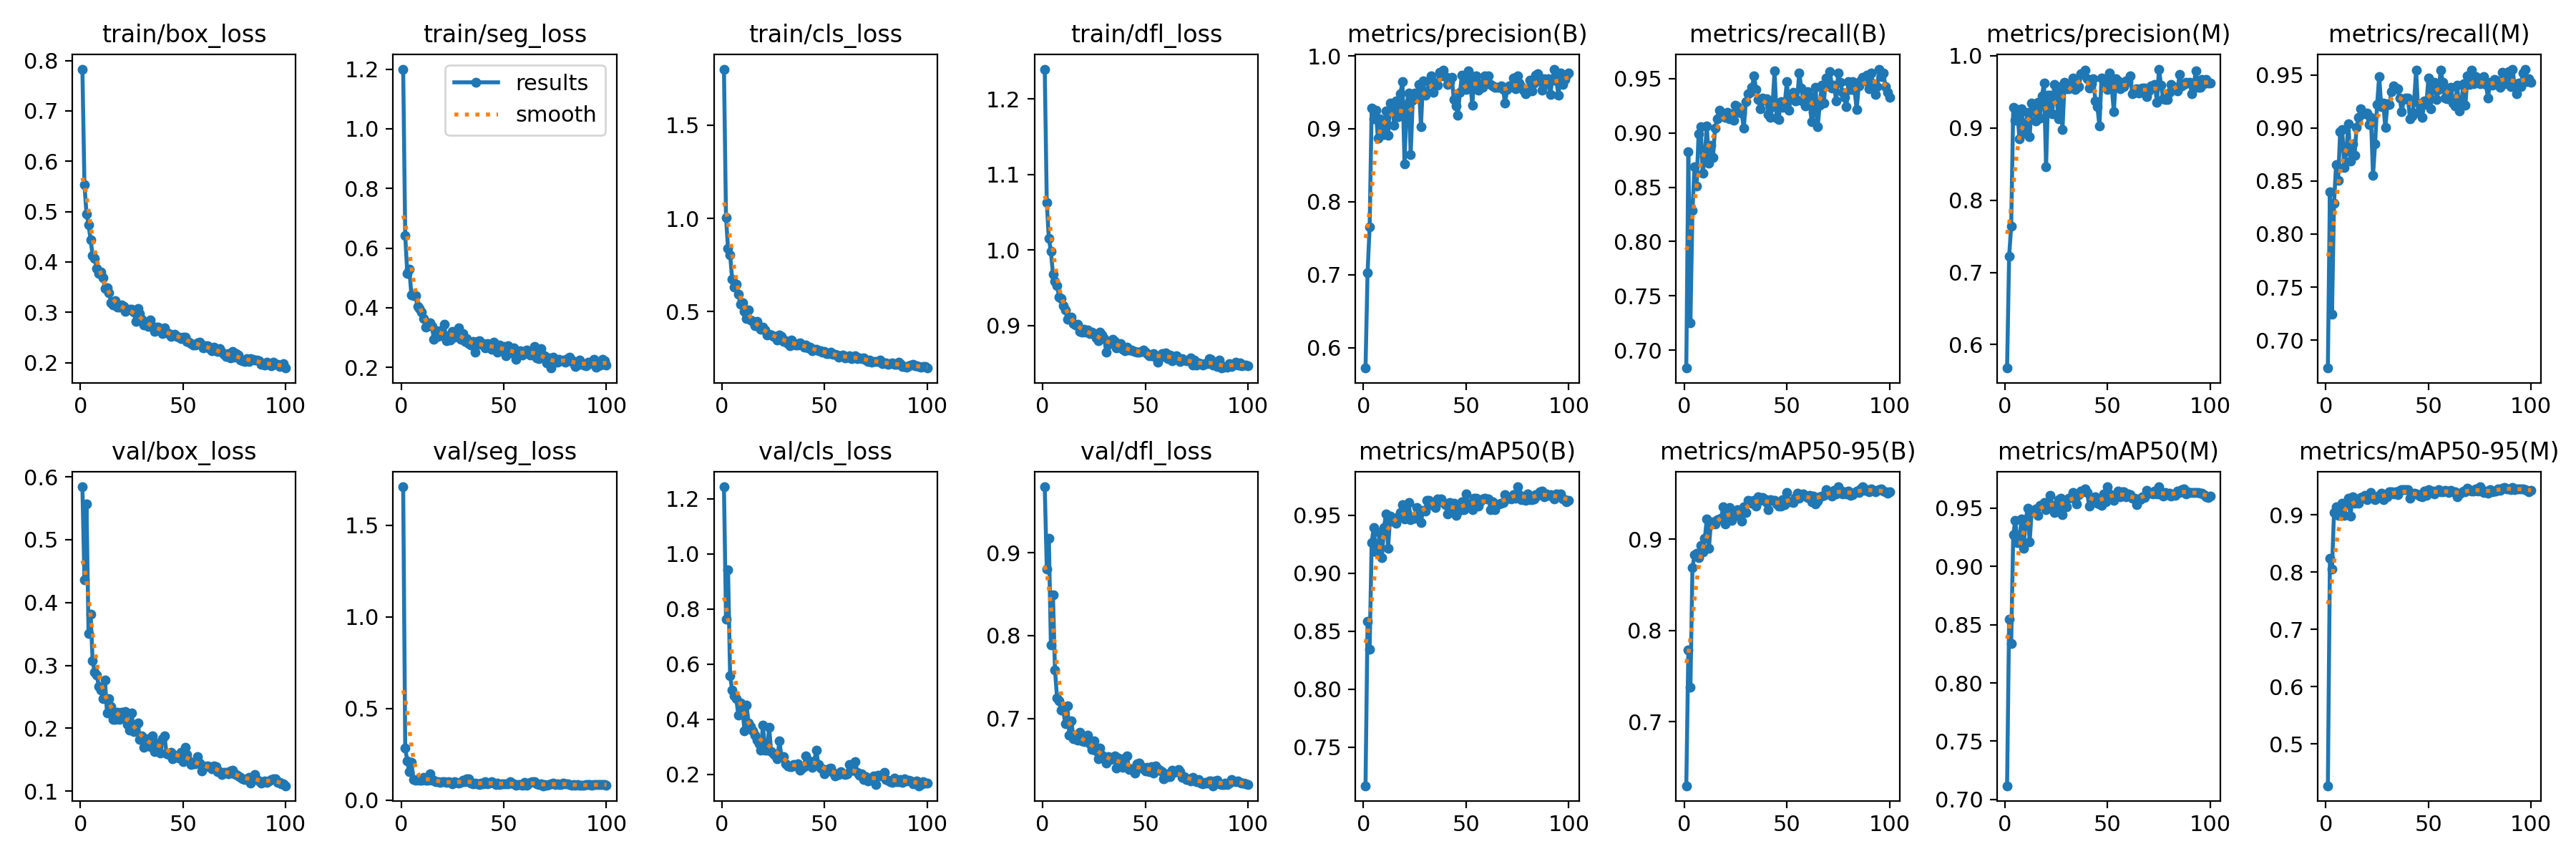


Validavimo painiavos matrica (confusion_matrix.png):


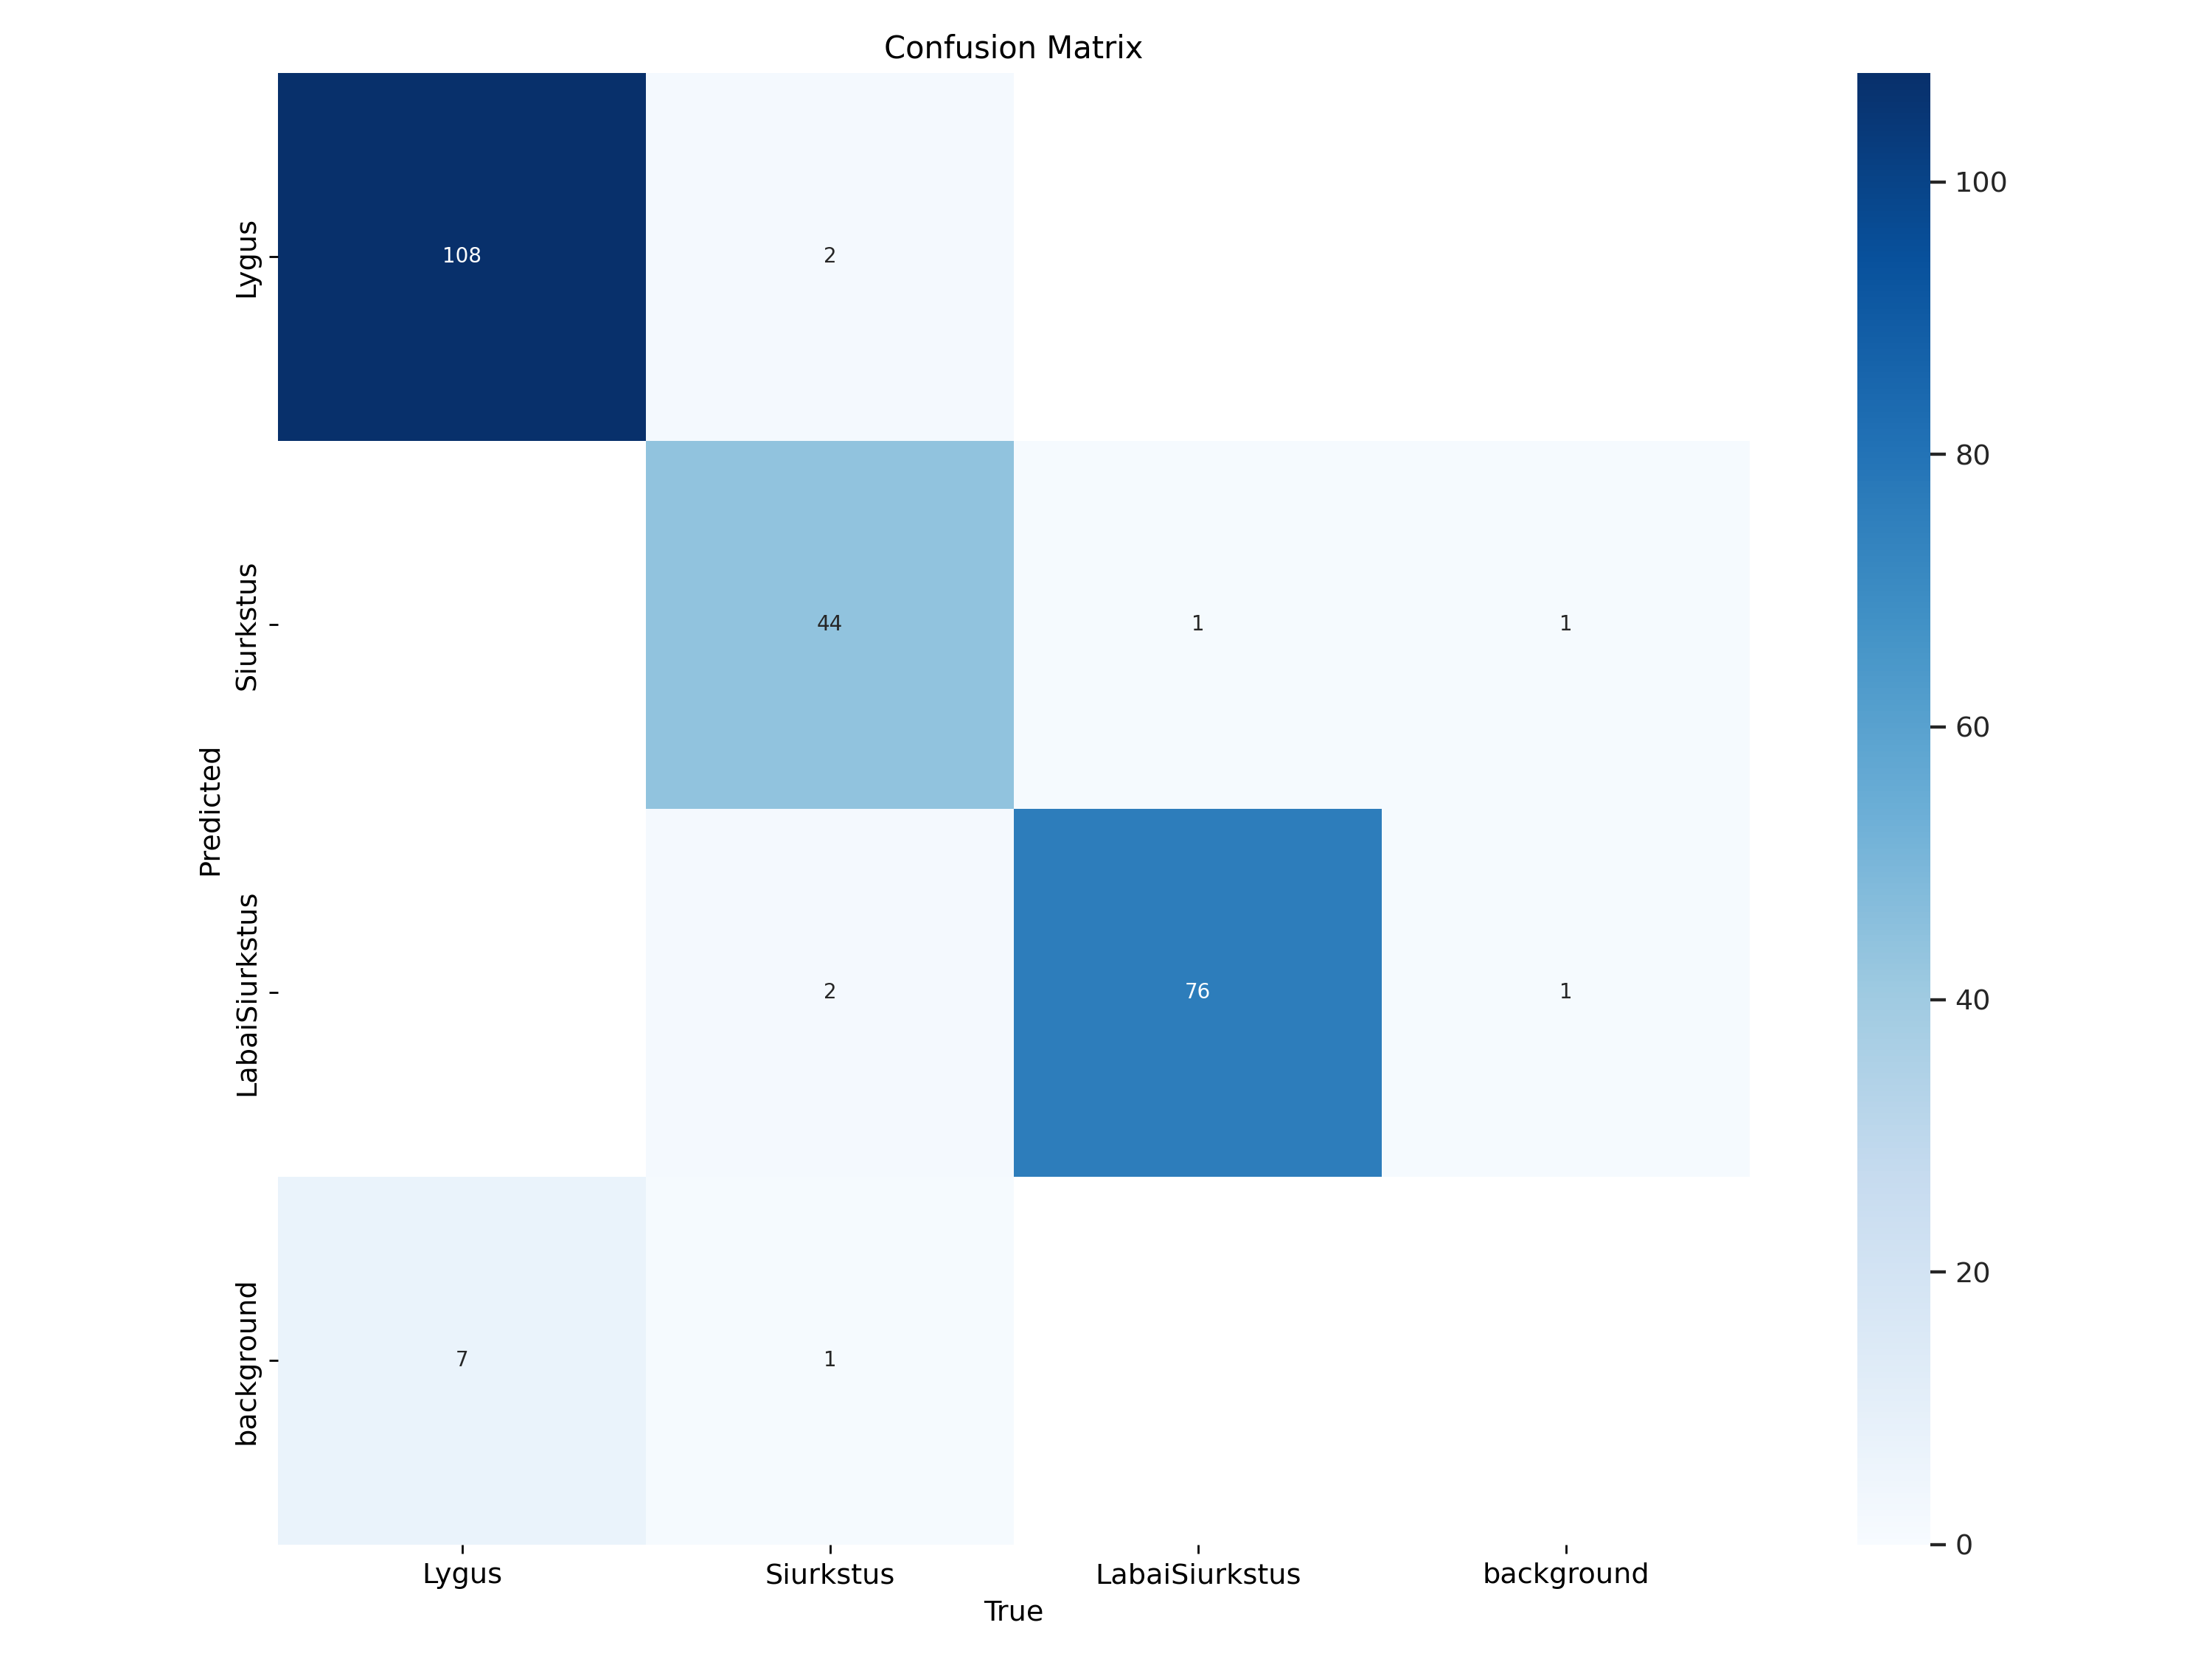

Mokymo procesas sėkmingai baigtas.


In [ ]:
#@title 6. Modelio mokymas kelio dangos šiurkštumo nustatymui
def train_road_roughness_model():
    """
    Mokome YOLOv8 segmentavimo modelį kelio dangos šiurkštumo nustatymui,
    naudojant optimizuotus parametrus ir išlaikant bazinę projekto struktūrą.
    """
    # Nustatome bazinį žurnalo registravimą
    logging.basicConfig(level=logging.INFO,
                      format='%(asctime)s - %(levelname)s - %(message)s')
    logger = logging.getLogger('train_export')

    print("\nRuošiame kelio dangos šiurkštumo segmentavimo mokymą su optimizuotais parametrais...")
    logger.info("Pradedamas kelio dangos šiurkštumo segmentavimo mokymas")

    # Modelio įkėlimo logika
    try:
        logger.info("Bandoma įkelti YOLOv8n-seg modelį...")
        model = YOLO('yolov8n-seg.pt')
        initial_model_name = 'yolov8n-seg'
        logger.info("Sėkmingai įkeltas YOLOv8n-seg modelis!")
    except Exception as e1:
        logger.warning(f"YOLOv8n-seg neprieinamas: {str(e1)}")
        try:
            logger.info("Bandoma įkelti YOLOv8s-seg modelį...")
            model = YOLO('yolov8s-seg.pt')  # Bandome mažesnį modelį
            initial_model_name = 'yolov8s-seg'
            logger.info("Sėkmingai įkeltas YOLOv8s-seg modelis!")
        except Exception as e2:
            logger.error(f"Nepavyko įkelti jokio modelio: {e2}")
            print(f"KLAIDA: Nepavyko įkelti jokio modelio: {e2}")
            return None, None, None  # Negalime tęsti be modelio

    logger.info(f"Naudojamas modelis: {initial_model_name}")
    print(f"Naudojamas modelis: {initial_model_name}")

    # --- Mokymo parametrai optimizuoti šiurkštumo nustatymui ---
    epochs = 120             # Šiek tiek sutrumpintas epochų skaičius
    imgsz = 800              # Didelė raiška tekstūrai atpažinti
    patience = 25            # Ankstyvasis stabdymas su 25 kantrybės epochomis
    batch_size = 12          # Vidutinis partijos dydis

    lr0 = 0.0002 # From Better
    lrf = 0.005 # From Better
    weight_decay = 0.0005    # Svorių mažėjimas
    warmup_epochs = 5.0      # Apšilimo epochos
    dropout = 0.1            # Išmetimo koeficientas
    save_period = 20         # Išsaugoti modelį kas 20 epochų
    close_mosaic = 20        # Išjungti mozaikos augmentaciją po 15 epochų

    # Subalansuota augmentacijos konfigūracija šiurkštumo nustatymui
    aug_params = {
        'hsv_h': 0.015,      # Mažiau HSV hue manipuliacijų - mažas poveikis tekstūrai
        'hsv_s': 0.5,        # Daugiau HSV sotumas - pabrėžia tekstūros kontrastą
        'hsv_v': 0.4,        # Vidutinis HSV ryškumas
        'degrees': 5.0,      # Nedideli pasukimai
        'translate': 0.1,    # Nedideli poslinkiai
        'scale': 0.2,        # Vidutinis mastelio keitimas
        'fliplr': 0.5,       # Horizontalus apvertimas
        'flipud': 0.0,       # Nenaudojame vertikalaus apvertimo
        'mosaic': 0.3,       # Vidutinis mozaikos dažnis
        'mixup': 0.15,       # Vidutinis mixup
    }
    # --- Mokymo parametrų pabaiga ---

    # Pradedame mokymą
    device_to_use = 0 if torch.cuda.is_available() else 'cpu'
    print(f"\nPradedame mokymą ant {device_to_use}")
    print(f"Vaizdo dydis: {imgsz}, Partijos dydis: {batch_size}, Epochos: {epochs}")
    print(f"Naudojami svoriai iš dataset.yaml.")
    print(f"Naudojami optimizuoti parametrai kelio dangos šiurkštumo nustatymui.")

    logger.info(f"Pradedamas mokymas su {initial_model_name} modeliu")
    logger.info(f"Naudojamas įrenginys: {device_to_use}")
    logger.info(f"Parametrai: imgsz={imgsz}, batch={batch_size}, epochs={epochs}, lr0={lr0}, weight_decay={weight_decay}")
    logger.info(f"Augmentacijos parametrai (YOLO): {aug_params}")

    # Užtikriname, kad direktorijos egzistuoja
    for dir_path in [project_dir, results_dir, predictions_dir, exports_dir]:
         if not os.path.exists(dir_path):
            os.makedirs(dir_path, exist_ok=True)
            logger.info(f"Sukurta direktorija: {dir_path}")

    try:
        # --- Modelio mokymo iškvietimas su optimizuotais parametrais ---
        results = model.train(
            data=dataset_yaml,       # Naudojame YAML sukurtą 4 žingsnyje
            epochs=epochs,
            imgsz=imgsz,
            batch=batch_size,
            patience=patience,
            save=True,
            project=project_dir,     # Išsaugome rezultatus pagrindinėje projekto direktorijoje
            name='road_roughness_model', # Subdirektorija šiam paleidimui
            save_period=save_period,
            pretrained=True,         # Pradedame nuo iš anksto apmokytų svorių
            optimizer='AdamW',       # Naudojame AdamW optimizatorių
            lr0=lr0,
            lrf=lrf,
            weight_decay=weight_decay,
            warmup_epochs=warmup_epochs,
            augment=True,            # Įjungiame YOLO augmentacijas
            cache='ram',       # Pakeitimas iš 'ram' į 'disk'
            device=0 if torch.cuda.is_available() else 'cpu',
            plots=True,              # Generuojame grafikus
            cos_lr=True,             # Kosinuso LR planuotojas
            verbose=True,            # Rodome pažangą
            task='segment',
            dropout=dropout,
            single_cls=False,        # Daugelio klasių problema (3 klasės)
            close_mosaic=close_mosaic, # Uždarome mozaikos augmentaciją po X epochų
            **aug_params             # Taikome specifinius augmentacijos parametrus
        )
        # --- Modelio mokymo iškvietimo pabaiga ---

        logger.info("Apmokymas baigtas!")
        print("Mokymas baigtas!")

    except Exception as e:
        logger.error(f"Klaida mokymo metu: {str(e)}")
        print(f"Klaida mokymo metu: {str(e)}")
        traceback.print_exc()
        return None, None, None

    # Palaukti momentą
    time.sleep(2)

    # Ieškome geriausio modelio kelio
    best_model_path = os.path.join(project_dir, 'road_roughness_model', 'weights', 'best.pt')

    if not os.path.exists(best_model_path):
        logger.warning(f"Geriausias modelis nerastas standartiniame kelyje: {best_model_path}")
        # Bandome surasti bet kokį .pt modelį
        potential_models = glob.glob(os.path.join(project_dir, 'road_roughness_model', 'weights', '*.pt'))
        if potential_models:
            # Rūšiuojame pagal modifikavimo laiką ir imame naujausią
            potential_models.sort(key=os.path.getmtime, reverse=True)
            best_model_path = potential_models[0]
            logger.info(f"Naudojamas rastas modelis: {best_model_path}")
            print(f"Naudojame alternatyvų modelį: {best_model_path}")
        else:
            logger.error("Nepavyko rasti apmokyto modelio.")
            print("Modelio failai nerasti. Negalime tęsti.")
            return None, results, None

    logger.info(f"Geriausias modelis: {best_model_path}")
    print(f"Geriausias modelis: {best_model_path}")

    # Įkelti geriausią modelį
    try:
        best_model = YOLO(best_model_path)
    except Exception as e:
        logger.error(f"Klaida įkeliant geriausią modelį: {str(e)}")
        print(f"Klaida įkeliant geriausią modelį: {str(e)}")
        return None, results, None

    # --- Validavimas optimizuotas šiurkštumo nustatymui ---
    logger.info("\nVykdomas validavimas...")
    print("\nVykdome validavimą...")
    val_results = None
    try:
        val_results = best_model.val(
            data=dataset_yaml,
            split='val',
            imgsz=imgsz,
            batch=batch_size,
            plots=True,
            save_json=True,
            save_txt=True,
            project=results_dir,
            name='validation',
            task='segment',
            conf=0.35,         # Subalansuotas pasitikėjimo slenkstis
            iou=0.45           # IOU slenkstis
        )

        # Spausdiname pagrindines metrikas
        if hasattr(val_results, 'seg') and val_results.seg is not None:
             map50 = getattr(val_results.seg, 'map50', 'N/A')
             map_val = getattr(val_results.seg, 'map', 'N/A') # map50-95
             print(f"Validavimo mAP50: {map50:.4f}" if isinstance(map50, float) else f"Validavimo mAP50: {map50}")
             print(f"Validavimo mAP50-95: {map_val:.4f}" if isinstance(map_val, float) else f"Validavimo mAP50-95: {map_val}")
             logger.info(f"Validavimo mAP50: {map50}, mAP50-95: {map_val}")
        else:
             print("Validavimo segmentavimo metrikos nerastos.")
             logger.warning("Validavimo segmentavimo metrikos nerastos.")

    except Exception as e:
        logger.error(f"Klaida validavimo metu: {str(e)}")
        print(f"Klaida validavimo metu: {str(e)}")
        # Tęsiame nepaisant to

    # --- Prognozių testavimas su keliais slenksčiais ---
    print("\nVykdome testavimo prognozes su keliais slenksčiais...")
    logger.info("Vykdomos testavimo prognozės su keliais slenksčiais ir TTA")
    try:
        test_img_dir = os.path.join(dataset_root, 'images', 'test')
        all_test_files = os.listdir(test_img_dir)
        # Pasirenkame kelis skirtingus vaizdus
        num_test_samples = min(5, len(all_test_files))

        # Bandome atrinkti įvairių klasių vaizdus
        test_images_sample = []
        lygus_samples = [f for f in all_test_files if 'Lygus' in f]
        siurkstus_samples = [f for f in all_test_files if 'Siurkstus' in f and not 'LabaiSiurkstus' in f]
        labai_siurkstus_samples = [f for f in all_test_files if 'LabaiSiurkstus' in f]

        # Imame po bent vieną kiekvienos klasės vaizdą, jei įmanoma
        for samples_list in [lygus_samples, siurkstus_samples, labai_siurkstus_samples]:
            if samples_list:
                test_images_sample.append(random.choice(samples_list))

        # Jei dar trūksta iki norimo kiekio, papildome atsitiktinai
        while len(test_images_sample) < num_test_samples and all_test_files:
            remaining_needed = num_test_samples - len(test_images_sample)
            remaining_samples = [f for f in all_test_files if f not in test_images_sample]
            if not remaining_samples:
                break
            test_images_sample.extend(random.sample(remaining_samples, min(remaining_needed, len(remaining_samples))))

        # Jei vis dar turime per mažai, tiesiog naudojame atsitiktinius
        if len(test_images_sample) < num_test_samples:
            test_images_sample = random.sample(all_test_files, num_test_samples)

        test_images_paths = [os.path.join(test_img_dir, f) for f in test_images_sample]
        print(f"Testavimui pasirinkti vaizdai: {test_images_sample}")

        # Vykdome prognozes su skirtingais slenksčiais
        thresholds = [0.15, 0.25, 0.35, 0.45]

        for img_path in test_images_paths:
            if not os.path.exists(img_path):
                logger.warning(f"Testavimo vaizdas nerastas: {img_path}")
                continue
            img_name = os.path.basename(img_path)
            logger.info(f"Vykdoma prognozė vaizdui: {img_name}")

            for thresh in thresholds:
                pred_results = best_model.predict(
                    source=img_path,
                    save=True,
                    project=predictions_dir,
                    name=f"pred_{os.path.splitext(img_name)[0]}_thresh_{int(thresh*100)}",
                    conf=thresh,       # Dabartinis slenkstis
                    task='segment',
                    imgsz=imgsz,
                    show=False,
                    save_txt=True,
                    save_conf=True,
                    boxes=True,
                    retina_masks=True, # Naudojame aukštos kokybės kaukes
                    line_width=2
                )
                logger.info(f"  Prognozė baigta: {img_name} (slenkstis {thresh})")

            # Taip pat vykdome vieną testą su augmentacija testavimo metu (TTA)
            logger.info(f"Vykdoma prognozė su TTA: {img_name}")
            pred_results_tta = best_model.predict(
                source=img_path,
                save=True,
                project=predictions_dir,
                name=f"pred_{os.path.splitext(img_name)[0]}_tta",
                conf=0.25,
                task='segment',
                imgsz=imgsz,
                show=False,
                save_txt=True,
                save_conf=True,
                boxes=True,
                retina_masks=True,
                line_width=2,
                augment=True    # Įjungiame testavimo metu augmentaciją
            )
            logger.info(f"  Prognozė su TTA baigta: {img_name}")

    except Exception as e:
        logger.error(f"Klaida prognozės testavimo metu: {str(e)}")
        print(f"Klaida prognozės testavimo metu: {str(e)}")
    # --- Prognozių testavimo pabaiga ---

    # --- Modelių eksportavimas (PT, ONNX) ---
    print("\nEksportuojame modelius (PT, ONNX)...")
    logger.info("Eksportuojami modeliai PT, ONNX formatais")
    export_success = {'pt': False, 'onnx': False}

    # Apibrėžiame eksporto kelius
    model_base_name = f"road_roughness_seg_{initial_model_name}"
    pt_path = os.path.join(exports_dir, f'{model_base_name}.pt')
    onnx_path = os.path.join(exports_dir, f'{model_base_name}.onnx')

    try:
        # 1. Kopijuojame PT modelį
        shutil.copy(best_model_path, pt_path)
        logger.info(f"PyTorch modelis nukopijuotas į: {pt_path}")
        print(f"PyTorch modelis nukopijuotas į: {pt_path}")
        export_success['pt'] = True

        # 2. Eksportuojame į ONNX
        logger.info("Eksportuojama į ONNX formatą...")
        print("Eksportuojama į ONNX formatą...")

        # Eksporto funkcija pagal nutylėjimą išsaugo failą toje pačioje direktorijoje kaip modelis
        onnx_export_result_path = best_model.export(format='onnx', imgsz=imgsz, simplify=True)

        # Surandame numatytą kelią
        default_onnx_name = os.path.splitext(best_model_path)[0] + '.onnx'

        if os.path.exists(default_onnx_name):
             shutil.move(default_onnx_name, onnx_path) # Perkeliame į eksporto direktoriją
             logger.info(f"ONNX modelis eksportuotas ir perkeltas į: {onnx_path}")
             print(f"ONNX modelis eksportuotas ir perkeltas į: {onnx_path}")
             export_success['onnx'] = True
        elif onnx_export_result_path and os.path.exists(onnx_export_result_path):
             # Jei eksportas grąžino kelią ir jis egzistuoja
             shutil.move(onnx_export_result_path, onnx_path)
             logger.info(f"ONNX modelis eksportuotas (iš {onnx_export_result_path}) ir perkeltas į: {onnx_path}")
             print(f"ONNX modelis eksportuotas (iš {onnx_export_result_path}) ir perkeltas į: {onnx_path}")
             export_success['onnx'] = True
        else:
             logger.error("ONNX eksportavimas baigtas, bet failas nerastas.")
             print("ONNX eksportavimas baigtas, bet failas nerastas.")

    except Exception as e:
        logger.error(f"Klaida modelio eksportavimo metu: {str(e)}")
        print(f"Klaida modelio eksportavimo metu: {str(e)}")
        traceback.print_exc()
    # --- Eksportavimo pabaiga ---

    # Mokymo rezultatai
    print("\nMokymo Rezultatai:")
    if hasattr(results, 'metrics') and results.metrics:
         final_fitness = results.metrics.get('fitness', 'N/A')
         print(f"  Galutinis tinkamumo balas (fitness): {final_fitness:.4f}" if isinstance(final_fitness, float) else f"  Galutinis tinkamumo balas (fitness): {final_fitness}")

    # Validavimo rezultatai
    print("\nValidavimo Rezultatai:")
    if val_results and hasattr(val_results, 'seg'):
         map50 = getattr(val_results.seg, 'map50', 'N/A')
         map_val = getattr(val_results.seg, 'map', 'N/A')
         print(f"  Validavimo mAP50: {map50:.4f}" if isinstance(map50, float) else f"  Validavimo mAP50: {map50}")
         print(f"  Validavimo mAP50-95: {map_val:.4f}" if isinstance(map_val, float) else f"  Validavimo mAP50-95: {map_val}")
    else:
        print("  Validavimo metrikos negautos arba nepavyko.")

    # Eksportavimo informacija
    print("\nEksportuoti modeliai:")
    print(f"  PyTorch (.pt): {pt_path if export_success['pt'] else 'Nepavyko'}")
    print(f"  ONNX (.onnx): {onnx_path if export_success['onnx'] else 'Nepavyko'}")
    print("\nRezultatai išsaugoti:")
    print(f"  Projekto direktorija: {project_dir}")
    print(f"  Mokymo eiga/grafikai: {os.path.join(project_dir, 'road_roughness_model')}")
    print(f"  Validavimo rezultatai: {os.path.join(results_dir, 'validation')}")
    print(f"  Prognozių pavyzdžiai: {predictions_dir}")
    print(f"  Eksportuoti modeliai: {exports_dir}")
    print("="*70)

    # Rodome rezultatų grafikus (jei yra)
    try:
        results_png_path = os.path.join(project_dir, 'road_roughness_model', 'results.png')
        confusion_matrix_path = os.path.join(results_dir, 'validation', 'confusion_matrix.png')

        if os.path.exists(results_png_path):
            print("\nMokymo rezultatai (results.png):")
            display(Image(results_png_path))
        if os.path.exists(confusion_matrix_path):
            print("\nValidavimo painiavos matrica (confusion_matrix.png):")
            display(Image(confusion_matrix_path))

    except Exception as e:
        logger.warning(f"Nepavyko parodyti rezultatų grafikų: {e}")
        # Tyliai praeiname, jei nepavyksta rodyti

    return best_model, results, val_results
# --- train_road_roughness_model funkcijos pabaiga ---

# Vykdyti mokymo funkciją
if __name__ == "__main__":
    # Nustatome atsitiktinių skaičių generatoriaus sėklą atkartojamumui
    random.seed(42)
    np.random.seed(42)
    torch.manual_seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(42)
        # Galima įjungti šiuos parametrus didesniam determinizmui, bet jie gali paveikti našumą
        # torch.backends.cudnn.deterministic = True
        # torch.backends.cudnn.benchmark = False

    print("Pradedamas mokymo procesas...")
    model, train_res, val_res = train_road_roughness_model()
    if model:
        print("Mokymo procesas sėkmingai baigtas.")
    else:
        print("Mokymo procesas susidūrė su klaida.")